Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [44]:
from random import random, seed
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
from sklearn.model_selection import ParameterGrid
import time

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [2]:
UNIVERSE_SIZE = 100_000
NUM_SETS = 10_000
DENSITY = 0.3

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [3]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [4]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

In [9]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(np.True_, np.float64(841052547.0129727))

In [19]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(np.True_, np.float64(423479351.67089576))

# Let's start!

In [6]:
# Function used to tweak current solution
def tweak(sol, rate=0.8):
    new_solution = sol.copy()
    tweaked = 0
    while tweaked==0 or np.random.random() < rate:
        random_index = np.random.randint(0,NUM_SETS)
        new_solution[random_index] = 1-new_solution[random_index]
        tweaked = 1
    return new_solution

# Function used to perform Simulated Annealing
def S_A(a,b,temp=1):
    Max = max(a,b)
    Min = min(a,b)
    return np.exp(-(Max-Min)/temp)

In [48]:
# Function used to reach a local maximum performing a  simulated annealing Hill Climbing
# See README.md for more information about the function and its parameters

def climb(num_steps=10_000, num_samples=1, prob=0.75, n_prob_schedule=30, temperature=None, plot=False):
    #generate a random valid initial solution
    initial_solution = np.random.randint(0,2, size=NUM_SETS) == 1
    while valid(initial_solution)==False:
        initial_solution = np.random.randint(0,2, size=NUM_SETS) == 1

    history = []
    current_solution = initial_solution.copy()
    
    # Hill Climb
    start = time.time()
    for i in range(num_steps):
        best_so_far = current_solution.copy()
    
        # parameter schedule
        if i in np.arange(num_steps/10, num_steps, step=num_steps/n_prob_schedule):
            prob *= 0.9

        # generate candidate steps
        for _ in range(num_samples):
            temp_sol = tweak(current_solution, rate=prob)
            if cost(temp_sol) < cost(best_so_far):
                best_so_far = temp_sol
            elif temperature!=None and np.random.random() < S_A(cost(temp_sol),cost(best_so_far), temp=temperature):
                best_so_far = temp_sol

        if valid(best_so_far)==True:
            current_solution=best_so_far
        history.append(-cost(current_solution))

    end = time.time()    
    
    #Plot some results
    if plot==True:
        plt.figure(figsize=(15,5))
        plt.plot(range(num_steps),history)
        plt.xlabel("n_iteration")
        plt.ylabel("Fitness")
        plt.show()
        print(f"Initial State: valid={valid(initial_solution)}, cost={cost(initial_solution)}")
        print(f"Current State: valid={valid(current_solution)}, cost={cost(current_solution)}")
        print(f"Executed in {end-start:.4} seconds")
    
    return (valid(current_solution),cost(current_solution))

## Instance 1

In [79]:
UNIVERSE_SIZE = 100
NUM_SETS = 10
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

# DON'T EDIT THESE LINES!
SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.power(SETS.sum(axis=1), 1.1)

In [ ]:
## Parameters to be tuned
parameters = {
    "num_samples": [1, 5],
    "prob": [0.4, 0.65, 0.9],
    "n_prob_schedule": [10, 20],
    "temperature": [None, 2, 10]
}

n_simulation_per_config = 100
results = []
for config in ParameterGrid(parameters):
    metrics = []
    for _ in range(n_simulation_per_config):
        test_sol = climb(**config)
        metrics.append(test_sol[1])
    results.append(np.mean(metrics))
    
best_stp = list(ParameterGrid(parameters))[np.argmin(results)]

In [59]:
print(best_stp)

{'n_prob_schedule': 10, 'num_samples': 1, 'prob': 0.4, 'temperature': None}


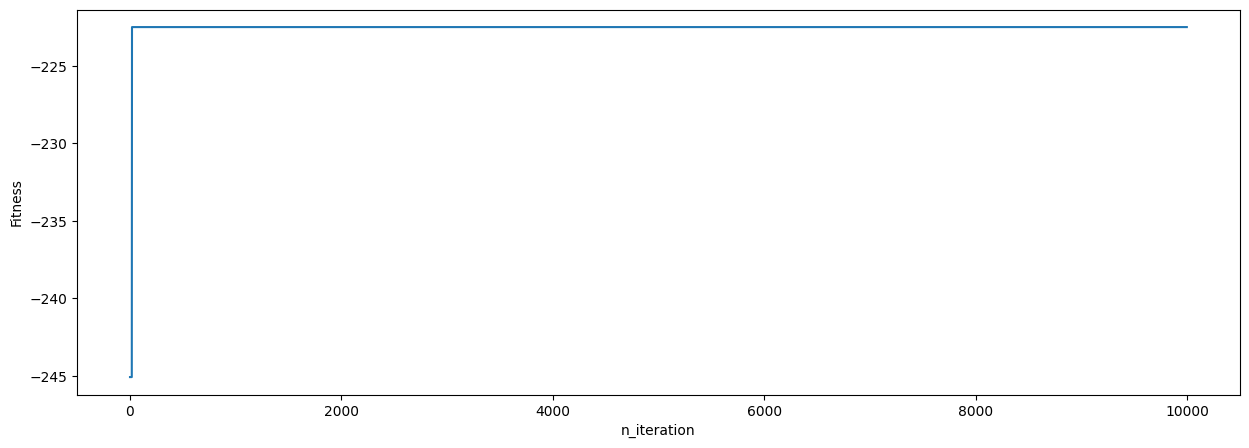

Initial State: valid=True, cost=245.0674417698619
Current State: valid=True, cost=222.49940329675707
Executed in 0.245 seconds


In [80]:
instance_one = climb(**best_stp, plot=True)

## Instance 2


In [81]:
UNIVERSE_SIZE = 1_000
NUM_SETS = 100
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

# DON'T EDIT THESE LINES!
SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.power(SETS.sum(axis=1), 1.1)

In [82]:
## Parameters to be tuned
parameters = {
    "num_samples": [1, 5],
    "prob": [0.4, 0.65, 0.9],
    "n_prob_schedule": [10, 20],
    "temperature": [None, 2]
}

In [ ]:
n_simulation_per_config = 100
results = []
for config in ParameterGrid(parameters):
    metrics = []
    for _ in range(n_simulation_per_config):
        test_sol = climb(**config)
        metrics.append(test_sol[1])
    results.append(np.mean(metrics))
    
best_stp_02 = list(ParameterGrid(parameters))[np.argmin(results)]

In [84]:
print(best_stp_02)

{'n_prob_schedule': 10, 'num_samples': 5, 'prob': 0.65, 'temperature': 2}


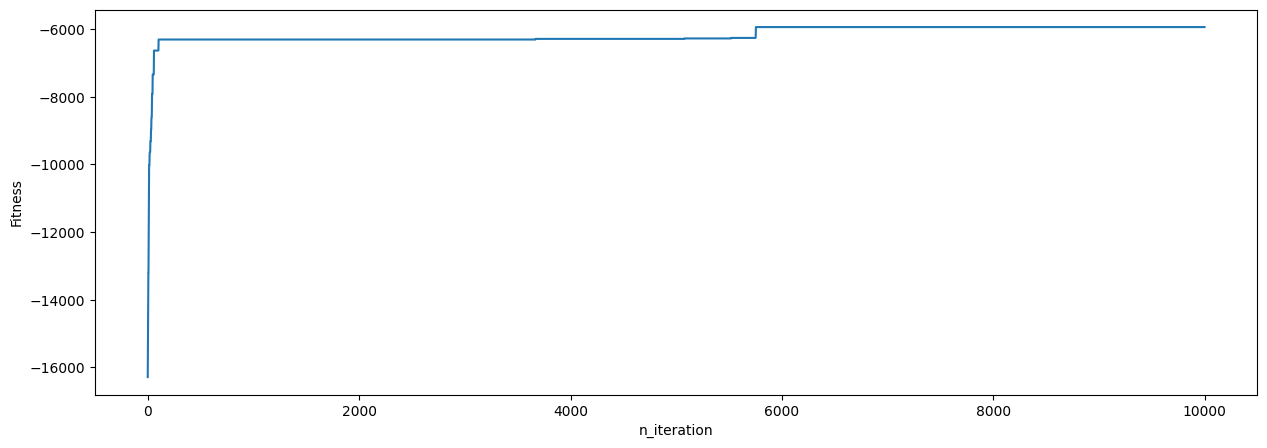

Initial State: valid=True, cost=16316.57793838262
Current State: valid=True, cost=5938.313524235966
Executed in 1.012 seconds


In [88]:
instance_02 = climb(**best_stp_02, plot=True)

## Instance 3


In [89]:
UNIVERSE_SIZE = 100_00
NUM_SETS = 1000
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

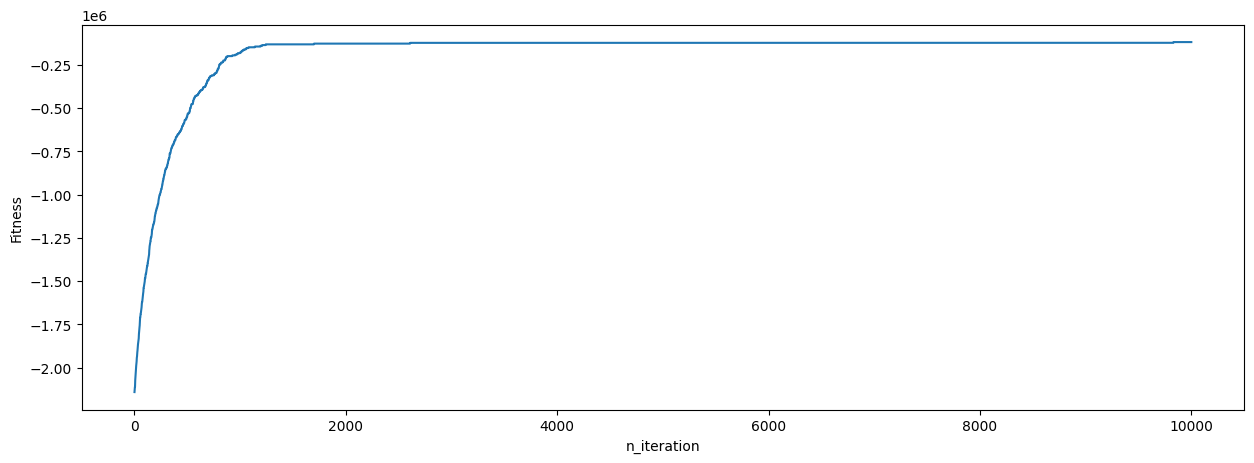

Initial State: valid=True, cost=2144967.0626820857
Current State: valid=True, cost=118248.70969877702
Executed in 1.703 seconds


In [104]:
# we use the same parameter configuration tuned at instance 2
instance_03 = climb(**best_stp_02, plot=True)

Note 1

In [ ]:
# Due to the increased computational power needed to run the last three instances
#  we do not perform a Grid search to fine tune the hyperparameters.
# The parametrs are tuned using a "trial and error" procedure, with a small number of tries, 
# starting from the configuration of Instance 2

Note 2

In [ ]:
# Since the number of sets is big, the convergence of the algorithm is slower than the previous instances.
# For this reason the number of steps performed to reach the maximum has been increased to 100_000

## Instance 4

In [40]:
UNIVERSE_SIZE = 100_000
NUM_SETS = 10_000
DENSITY = 0.1

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

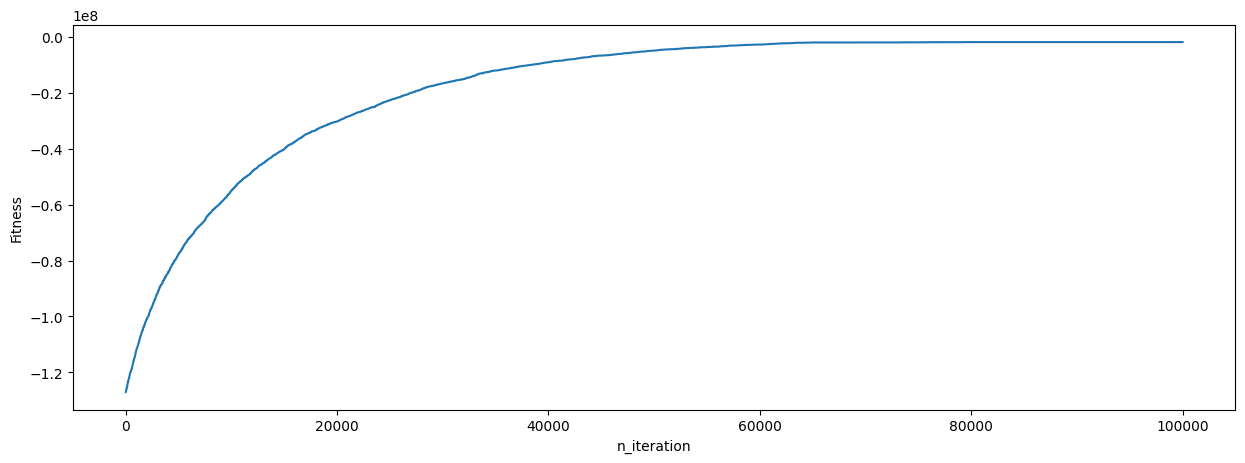

Initial State: valid=True, cost=127003332.04025184
Current State: valid=True, cost=1967105.6205522465
Executed in 1.986e+03 seconds


In [42]:
instance_04_sol = climb(plot=True,num_steps=100000,prob=0.65,n_prob_schedule=10)

## Instance 5

In [38]:
UNIVERSE_SIZE = 100_000
NUM_SETS = 10_000
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

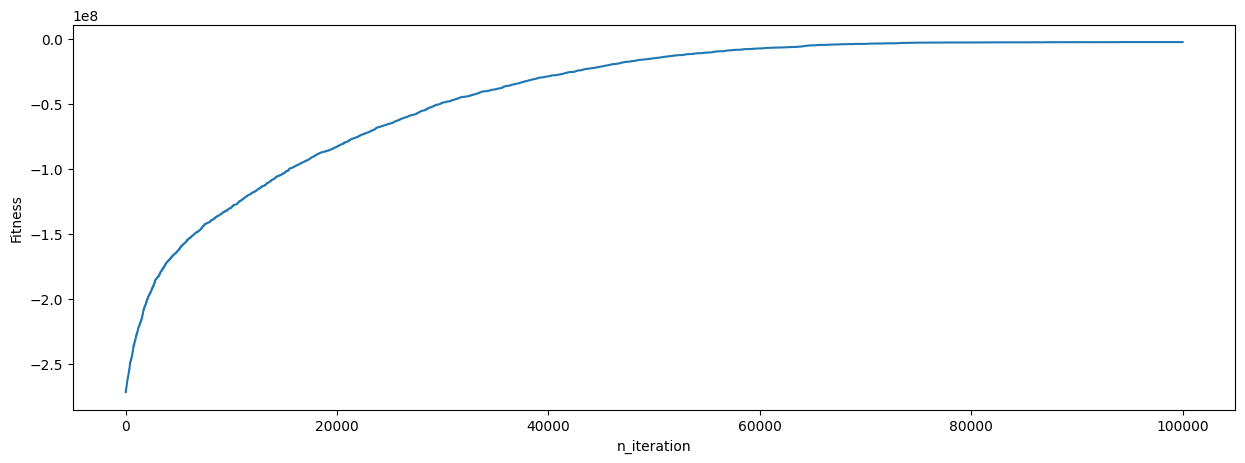

Initial State: valid=True, cost=271592088.83167434
Current State: valid=True, cost=2190608.481320333
Executed in 2.075e+03 seconds


In [39]:
local_max_02 = climb(plot=True,num_steps=100000,prob=0.9,n_prob_schedule=20)

## Instance 6

In [35]:
UNIVERSE_SIZE = 100_000
NUM_SETS = 10_000
DENSITY = 0.3

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

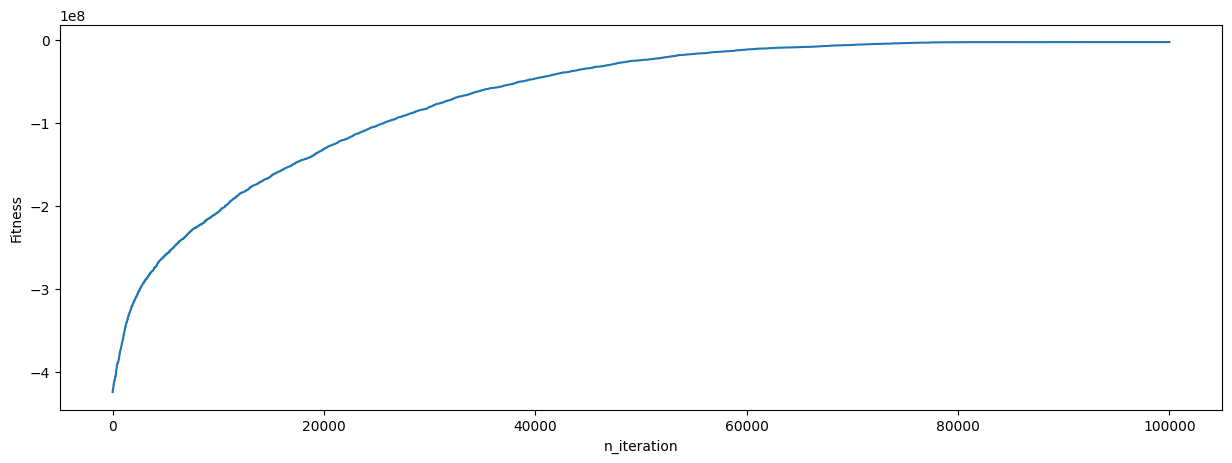

Initial State: valid=True, cost=424746103.50480163
Current State: valid=True, cost=2342890.637663764
Executed in 2.122e+03 seconds


In [37]:
local_max = climb(plot=True,num_steps=100000,prob=0.9,n_prob_schedule=20)

Comments